<a href="https://colab.research.google.com/github/ayushabhinav/BikeSharingLinearRegression/blob/main/BikeSharingLinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/drive')

In [ ]:
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [ ]:
data_file = '/drive/MyDrive/day.csv'

##### Load Data #####

In [ ]:
#loading data
data = pd.read_csv(data_file)
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


##### Perform Basic Sanity in Data #####

In [ ]:
#checking for null values
data.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [ ]:
#Checking datatype of columns
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [ ]:
#describe data
data.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.995890,0.690411,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.000339,0.462641,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [ ]:
#segregating the categorical and numerical columns
cat_cols = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
num_cols = ['temp', 'atemp', 'hum', 'windspeed','casual', 'registered', 'cnt']

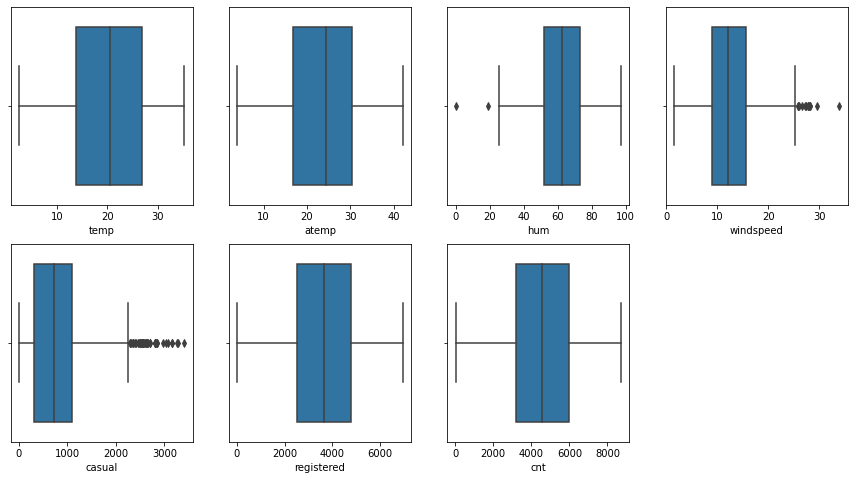

In [ ]:
#detecting outlier on numerical columns
import math
fig = plt.figure(figsize=[15,8])
for i, col in enumerate(num_cols):
  plt.subplot(math.ceil(len(num_cols) / 4) , 4, i+1)
  sns.boxplot(data=data, x=col)
plt.show()

# windspeed and humidity has outliers.

In [ ]:
#cheking outliers on humidity.
data[data.hum < 20]

#one row has humidity as 0. This looks error in recording humidity.

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
49,50,19-02-2018,1,0,2,0,1,1,1,16.365847,19.5702,18.7917,34.000021,532,1103,1635
68,69,10-03-2018,1,0,3,0,6,0,3,15.952731,19.2834,0.0000,17.545759,46,577,623


In [ ]:
# drop errored row
data.drop(index=data[data.hum == 0.00].index, inplace=True)

In [ ]:
#checking outliers on windspeed.
q1, q3= np.percentile(data.windspeed, [25,75])
UL= q3 + 1.5*(q3-q1)
data[data.windspeed > UL]

#windspeed is continuous and looks genuine data. They do not need dropping

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
44,45,14-02-2018,1,0,2,0,3,1,1,17.015000,19.91750,37.5833,27.999836,208,1705,1913
49,50,19-02-2018,1,0,2,0,1,1,1,16.365847,19.57020,18.7917,34.000021,532,1103,1635
93,94,04-04-2018,2,0,4,0,3,1,1,23.506653,27.14645,42.6250,25.833257,734,2381,3115
94,95,05-04-2018,2,0,4,0,4,1,2,16.980847,19.91750,64.2083,26.000489,167,1628,1795
292,293,20-10-2018,4,0,10,0,6,0,1,19.509153,23.32625,63.6250,28.292425,471,3724,4195
382,383,18-01-2019,1,1,1,0,5,1,1,12.436653,13.76270,44.3333,27.833743,109,3267,3376
407,408,12-02-2019,1,1,2,0,2,1,1,5.227500,5.08290,46.4583,27.417204,73,1456,1529
420,421,25-02-2019,1,1,2,0,1,1,1,11.924153,12.78375,39.5833,28.250014,317,2415,2732
431,432,08-03-2019,1,1,3,0,5,1,1,21.627500,26.23020,56.7500,29.584721,486,4896,5382
432,433,09-03-2019,1,1,3,0,6,0,2,16.844153,19.85415,40.7083,27.791600,447,4122,4569


In [ ]:
#reseting the index aftre dropping the rows.
data.reset_index(inplace=True)

##### Explortory Data Analysis ##### 

In [ ]:
#custom function for plotting 
def myPlot(x, y, data=data, title=None):
  
  fig = plt.figure(figsize=[10,3])
  plt.subplot(1,2,1)
  sns.stripplot(data=data, x=x, y=y)
  plt.subplot(1,2,2)
  sns.boxplot(data=data, x=x, y=y)
  if title:
    plt.suptitle(title, fontsize=20, fontweight='bold')
  else:
    plt.suptitle(f'{x} Vs {y}', fontsize=20, fontweight='bold')

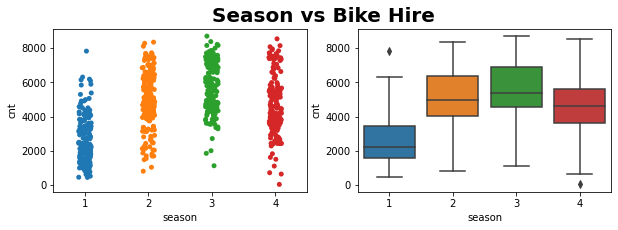

In [ ]:
#plotting season vs bike hire
myPlot('season', 'cnt', data, 'Season vs Bike Hire')

#Season Codes :- 1:spring, 2:summer, 3:fall, 4:winter
#Summer, Fall, Winter season has good traction of cycle demand. Spring has less demand comapred to other three.

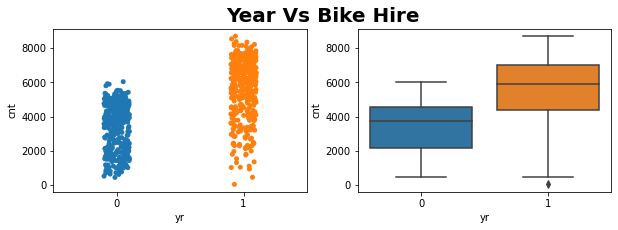

In [ ]:
#plotting year vs bike hire
myPlot('yr', 'cnt', data, 'Year Vs Bike Hire')

# year code :- 0: 2018, 1:2019
# 2019 has more bike hire as compared to previous year-2018

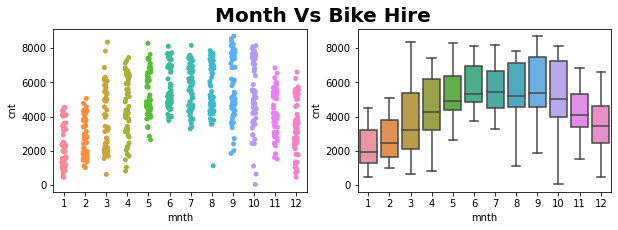

In [ ]:
#plotting months vs bike hire
myPlot('mnth', 'cnt', data, 'Month Vs Bike Hire')

# Summer and Fall months have high bike hire count. Winter months have less bike hiring. 

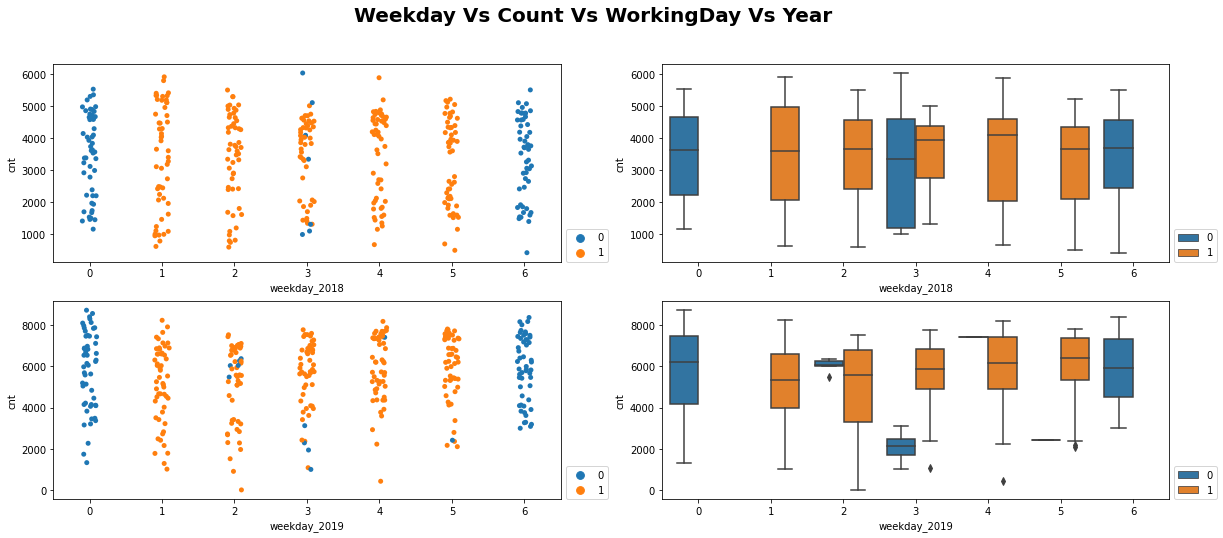

In [ ]:
# Weekday Vs Count Vs WorkingDay Vs Year 
fig = plt.figure(figsize=[20, 8])
data_2018 = data[data.yr==0]
data_2019 = data[data.yr==1]
plt.subplot(2,2,1)
sns.stripplot(data=data_2018, x='weekday', y='cnt', hue='workingday')
plt.xlabel('weekday_2018')
plt.legend(loc=[1.01,0])
plt.subplot(2,2,2)
sns.boxplot(data=data_2018, x='weekday', y='cnt', hue='workingday')
plt.xlabel('weekday_2018')
plt.legend(loc=[1.01,0])

plt.subplot(2,2,3)
sns.stripplot(data=data_2019, x='weekday', y='cnt', hue='workingday')
plt.xlabel('weekday_2019')
plt.legend(loc=[1.01,0])
plt.subplot(2,2,4)
sns.boxplot(data=data_2019, x='weekday', y='cnt', hue='workingday')
plt.xlabel('weekday_2019')
plt.legend(loc=[1.01,0])

plt.suptitle('Weekday Vs Count Vs WorkingDay Vs Year', fontsize=20, fontweight='bold')
plt.show()

# Bike Hire follows the same pattern for both weekdays and weekends.
# Weekdauys which are not working see lower bike hire.
# Bike hire in 2019 is higher than that of 2018

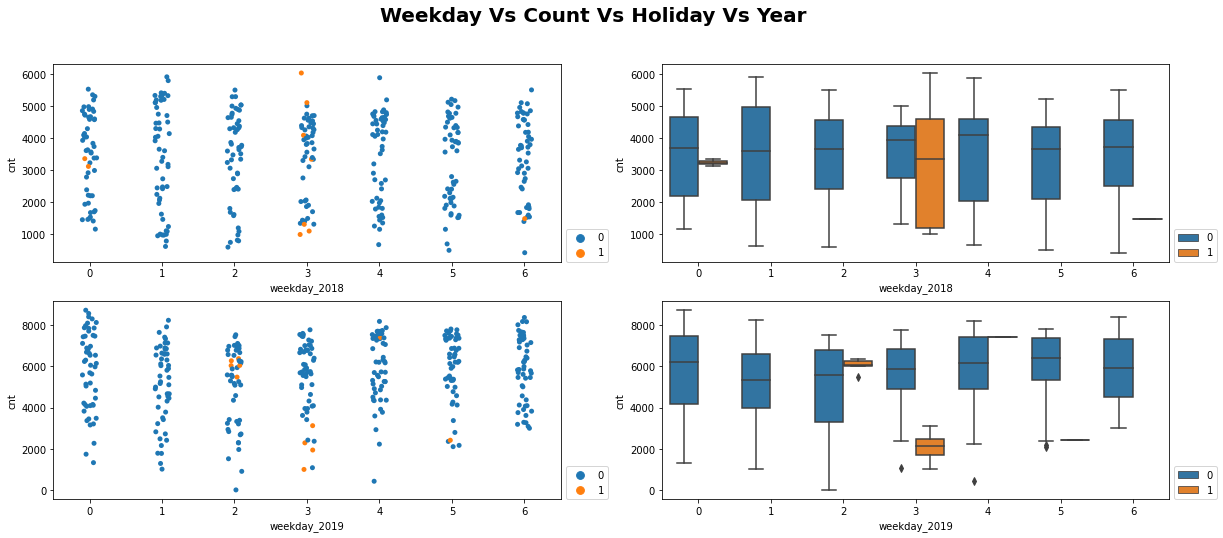

In [ ]:
# Weekday Vs Count Vs Holiday Vs Year
fig = plt.figure(figsize=[20, 8])
data_2018 = data[data.yr==0]
data_2019 = data[data.yr==1]
plt.subplot(2,2,1)
sns.stripplot(data=data_2018, x='weekday', y='cnt', hue='holiday')
plt.xlabel('weekday_2018')
plt.legend(loc=[1.01,0])
plt.subplot(2,2,2)
sns.boxplot(data=data_2018, x='weekday', y='cnt', hue='holiday')
plt.xlabel('weekday_2018')
plt.legend(loc=[1.01,0])

plt.subplot(2,2,3)
sns.stripplot(data=data_2019, x='weekday', y='cnt', hue='holiday')
plt.xlabel('weekday_2019')
plt.legend(loc=[1.01,0])
plt.subplot(2,2,4)
sns.boxplot(data=data_2019, x='weekday', y='cnt', hue='holiday')
plt.xlabel('weekday_2019')
plt.legend(loc=[1.01,0])

plt.suptitle('Weekday Vs Count Vs Holiday Vs Year', fontsize=20, fontweight='bold')
plt.show()

# 2019 has more bike hire than 2018
# Holiday doesnot make any visible difference in hiring pattern.

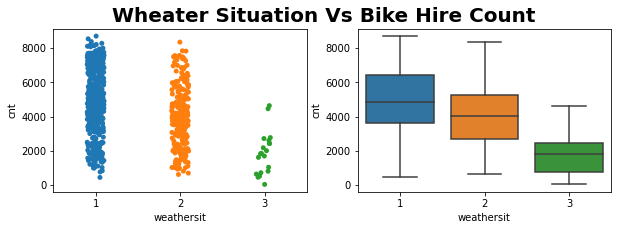

In [ ]:
# weathersit
myPlot(x='weathersit', y='cnt', data=data, title='Wheater Situation Vs Bike Hire Count')

# Wheather Situation Codes
# - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
# - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
# - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
# - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

# Wheather Situation drives bike hire count. Clear weather has more bike hire.

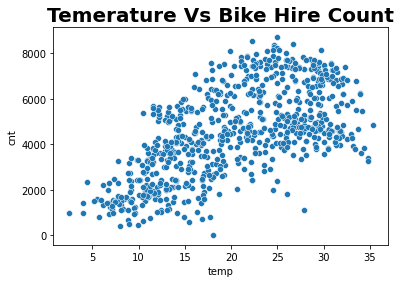

In [ ]:
# temperature Vs bike hire
plt.title('Temerature Vs Bike Hire Count', fontdict={'fontsize':20, 'fontweight':'bold'})
sns.scatterplot(x='temp', y='cnt', data=data)
plt.show()
# temerature has positive correlation with the bike hire count

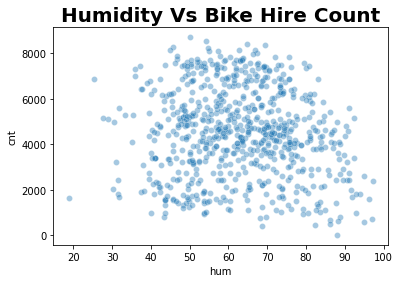

In [ ]:
# Humidity Vs bike hire
plt.title('Humidity Vs Bike Hire Count', fontdict={'fontsize':20, 'fontweight':'bold'})
sns.scatterplot(x='hum', y='cnt', data=data, alpha=0.4)
plt.show()
# It appears that bike hiring increases with humidity till 70 and then decreaes.

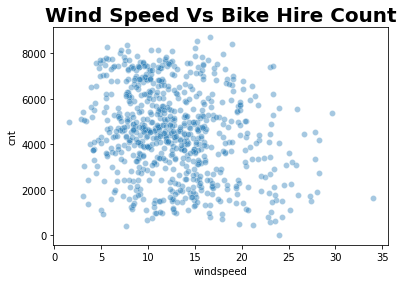

In [ ]:
# windspeed Vs bike hire
plt.title('Wind Speed Vs Bike Hire Count', fontdict={'fontsize':20, 'fontweight':'bold'})
sns.scatterplot(x='windspeed', y='cnt', data=data, alpha=0.4)
plt.show()
# Higher is the windspeed lower is the bike hire count.

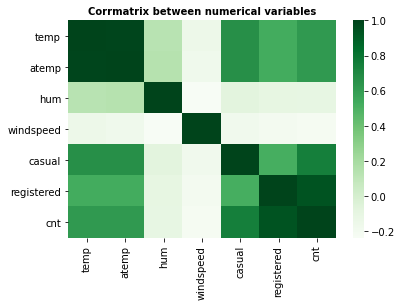

In [ ]:
# Corrmatrix between numerical variables
sns.heatmap(data[num_cols].corr('spearman'), cmap='Greens')
plt.title('Corrmatrix between numerical variables', fontdict={'fontsize':10, 'fontweight':'bold'})
plt.show()

# temperature has positive correlation with bike hire count.
# temp and atemp are highly positively related.
# casual, registered and hire count are positively related.
# windspeed and humidity are negatively related.

# Strong relation between some variables gives chance of multicollinearity.

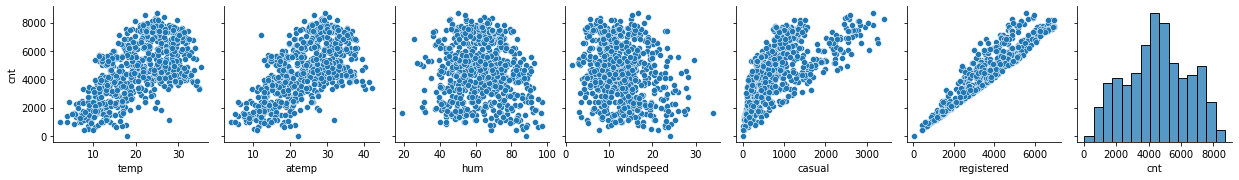

In [ ]:
#pair-plot between numerical columns wrt target.
sns.pairplot(data=data[num_cols], y_vars=['cnt'])
plt.show()

# temp and atemp has strong positive correlation with target variable - cnt 
# casual and registered also has strong positive correlation with cnt. but casual + registered = cnt. so we can ignore them.

##### train test split #####

In [ ]:
#dropping casual and registered as they constitute the part of cnt.
data.drop(columns=['casual', 'registered'], inplace=True)
cat_cols = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
num_cols = ['temp', 'atemp', 'hum', 'windspeed','cnt']

In [ ]:
#convert coded data into their original value. This helps in creating label for One hot encoding.
data['season'] = data.season.map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
data['yr'] = data.yr.map({0:'year_2018', 1:'year_2019'})
data['mnth'] = data.mnth.map({1:'jan', 2:'feb', 3:'mar', 4:'apr', 5:'may', 6:'jun',
               7:'jul', 8:'aug', 9:'sep', 10:'oct', 11:'nov', 12:'dec'})
data['holiday'] = data.holiday.map({0:'h_yes', 1:'h_no'})
data['weekday'] = data.weekday.map({0:'sun', 1:'mon', 2:'tue', 3:'wed', 4:'thu', 5:'fri', 6:'sat'})
data['workingday'] = data.workingday.map({0:'wor_no', 1:'wor_yes'})
data['weathersit'] = data.weathersit.map({1:'weth_1', 2:'weth_2', 3:'weth_3', 4:'weth_4'})

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#split into train and test data set. test_size is 30% and random_state=42
data_train, data_test = train_test_split(data, test_size=0.30, random_state=42)

In [ ]:
print(f'Shape(Train Dataset):{data_train.shape}')
print(f'Shape(Test Dataset) :{data_test.shape}')

Shape(Train Dataset):(510, 15)
Shape(Test Dataset) :(219, 15)


##### Preparing Data For Analysis ##### 

In [ ]:
#perform one-hot encoding of categorical variables.
from sklearn.preprocessing import OneHotEncoder

In [ ]:
#instantiate one hot encoder for different categorical variables
cat_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
cat_encoder.fit(data_train[cat_cols])
cat_encoder.categories_

[array(['fall', 'spring', 'summer', 'winter'], dtype=object),
 array(['year_2018', 'year_2019'], dtype=object),
 array(['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may',
        'nov', 'oct', 'sep'], dtype=object),
 array(['h_no', 'h_yes'], dtype=object),
 array(['fri', 'mon', 'sat', 'sun', 'thu', 'tue', 'wed'], dtype=object),
 array(['wor_no', 'wor_yes'], dtype=object),
 array(['weth_1', 'weth_2', 'weth_3'], dtype=object)]

In [ ]:
col_names = []
for i in cat_encoder.categories_:
  col_names.extend(i)
print(col_names)

['fall', 'spring', 'summer', 'winter', 'year_2018', 'year_2019', 'apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep', 'h_no', 'h_yes', 'fri', 'mon', 'sat', 'sun', 'thu', 'tue', 'wed', 'wor_no', 'wor_yes', 'weth_1', 'weth_2', 'weth_3']


In [ ]:
#create DF with one hot encoded columns. Here we are not dropping teh first dummy column . We will drop that during model building.

X = pd.DataFrame(cat_encoder.transform(data_train[cat_cols]), columns=col_names)
X.head()

,fall,spring,summer,winter,year_2018,year_2019,apr,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep,h_no,h_yes,fri,mon,sat,sun,thu,tue,wed,wor_no,wor_yes,weth_1,weth_2,weth_3
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
# scaling the numerical variables
from sklearn.preprocessing import MinMaxScaler
pred_scalar = MinMaxScaler()
scaled_num_data = pd.DataFrame(pred_scalar.fit_transform(data_train[num_cols[0:-1]]), columns=num_cols[0:-1])
scaled_num_data.head()

,temp,atemp,hum,windspeed
0,0.327133,0.322150,0.511344,0.327101
1,0.403972,0.404998,0.635834,0.419004
2,0.679142,0.672694,0.353111,0.618387
3,0.299051,0.263714,0.348686,0.680198
4,0.745598,0.682653,0.753345,0.110593


In [ ]:
#concat one hot encoded categorical columns with numerical columns
X_train = pd.concat([X, scaled_num_data], axis=1)
X_train.head()

,fall,spring,summer,winter,year_2018,year_2019,apr,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep,h_no,h_yes,fri,mon,sat,sun,thu,tue,wed,wor_no,wor_yes,weth_1,weth_2,weth_3,temp,atemp,hum,windspeed
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.327133,0.322150,0.511344,0.327101
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.403972,0.404998,0.635834,0.419004
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.679142,0.672694,0.353111,0.618387
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.299051,0.263714,0.348686,0.680198
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.745598,0.682653,0.753345,0.110593


In [ ]:
#target variable - y. scaling the target variable.
target_scalar = MinMaxScaler()
y_train = target_scalar.fit_transform(data_train.cnt.values.reshape(-1,1))

##### Creating LR Model #####

we will do feature selection manually in bottom up approach.

In [ ]:
import statsmodels.api as sm

In [ ]:
#trying one variable - temp
X_train_sm = X_train['temp']
X_train_sm = sm.add_constant(X_train_sm) 
lr_model1 = sm.OLS(y_train, X_train_sm)
result = lr_model1.fit()
result.summary()

# R2 is 39.5%
# temp is significant as per p-value

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     331.2
Date:                Sat, 03 Apr 2021   Prob (F-statistic):           2.38e-57
Time:                        06:39:58   Log-Likelihood:                 143.64
No. Observations:                 510   AIC:                            -283.3
Df Residuals:                     508   BIC:                            -274.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1451      0.021      6.803      0.000       0.103       0.187
temp           0.6505      0.036     18.199      0.000       0.580       0.721
==============================================================================
Omnibus:                       13.598   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                8.487
Skew:                           0.160   Prob(JB):                       0.0144
Kurtosis:                       2.455   Cond. No.                         5.81
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# trying two variable - temp, hum
vars = ['temp', 'hum'] 
X_train_sm = X_train[vars]
X_train_sm = sm.add_constant(X_train_sm) 
lr_model2 = sm.OLS(y_train, X_train_sm)
result = lr_model2.fit()
result.summary()

# R2 is 42.9%
# temp and humidity are significant as per p-value

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     190.8
Date:                Sat, 03 Apr 2021   Prob (F-statistic):           1.66e-62
Time:                        06:39:58   Log-Likelihood:                 158.74
No. Observations:                 510   AIC:                            -311.5
Df Residuals:                     507   BIC:                            -298.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2521      0.028      8.913      0.000       0.197       0.308
temp           0.6753      0.035     19.282      0.000       0.606       0.744
hum           -0.2278      0.041     -5.560      0.000      -0.308      -0.147
==============================================================================
Omnibus:                       16.439   Durbin-Watson:                   2.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.913
Skew:                           0.181   Prob(JB):                      0.00704
Kurtosis:                       2.421   Cond. No.                         7.49
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# trying two variable - temp, windspeed
vars = ['temp', 'windspeed'] 
X_train_sm = X_train[vars]
X_train_sm = sm.add_constant(X_train_sm) 
lr_model3 = sm.OLS(y_train, X_train_sm)
result = lr_model3.fit()
result.summary()

# R2 is 41.7%
# temp and windspeed are significant as per p-value

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     181.2
Date:                Sat, 03 Apr 2021   Prob (F-statistic):           4.20e-60
Time:                        06:39:58   Log-Likelihood:                 153.17
No. Observations:                 510   AIC:                            -300.3
Df Residuals:                     507   BIC:                            -287.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2362      0.029      8.011      0.000       0.178       0.294
temp           0.6267      0.036     17.633      0.000       0.557       0.696
windspeed     -0.1882      0.043     -4.393      0.000      -0.272      -0.104
==============================================================================
Omnibus:                       18.370   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               11.233
Skew:                           0.211   Prob(JB):                      0.00364
Kurtosis:                       2.408   Cond. No.                         7.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# trying variables - temp, hum, weather 
vars = ['temp', 'hum', 'weth_2', 'weth_3'] 
X_train_sm = X_train[vars]
X_train_sm = sm.add_constant(X_train_sm) 
lr_model4 = sm.OLS(y_train, X_train_sm)
result = lr_model4.fit()
result.summary()

# R2 is 44.9%
# temp, hum, wheather are significant as per p-value

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     102.8
Date:                Sat, 03 Apr 2021   Prob (F-statistic):           5.20e-64
Time:                        06:39:58   Log-Likelihood:                 167.58
No. Observations:                 510   AIC:                            -325.2
Df Residuals:                     505   BIC:                            -304.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2297      0.029      8.041      0.000       0.174       0.286
temp           0.6504      0.035     18.376      0.000       0.581       0.720
hum           -0.1278      0.053     -2.426      0.016      -0.231      -0.024
weth_2        -0.0330      0.021     -1.605      0.109      -0.073       0.007
weth_3        -0.2409      0.057     -4.219      0.000      -0.353      -0.129
==============================================================================
Omnibus:                       16.666   Durbin-Watson:                   2.139
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.206
Skew:                           0.191   Prob(JB):                      0.00608
Kurtosis:                       2.422   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# trying variables - temp, hum, weather, season
vars = ['temp', 'hum', 'weth_2', 'weth_3', 'spring', 'summer', 'winter'] 
X_train_sm = X_train[vars]
X_train_sm = sm.add_constant(X_train_sm) 
lr_model5 = sm.OLS(y_train, X_train_sm)
result = lr_model5.fit()
result.summary()

# R2 is 53.8%
# temp, humidity, wheather, season are significant as per p-value

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     83.40
Date:                Sat, 03 Apr 2021   Prob (F-statistic):           5.26e-80
Time:                        06:39:58   Log-Likelihood:                 212.36
No. Observations:                 510   AIC:                            -408.7
Df Residuals:                     502   BIC:                            -374.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2816      0.050      5.627      0.000       0.183       0.380
temp           0.5769      0.059      9.811      0.000       0.461       0.692
hum           -0.1772      0.049     -3.602      0.000      -0.274      -0.081
weth_2        -0.0318      0.019     -1.680      0.094      -0.069       0.005
weth_3        -0.2537      0.053     -4.813      0.000      -0.357      -0.150
spring        -0.0948      0.036     -2.634      0.009      -0.165      -0.024
summer         0.0353      0.022      1.570      0.117      -0.009       0.079
winter         0.1117      0.028      3.964      0.000       0.056       0.167
==============================================================================
Omnibus:                       11.905   Durbin-Watson:                   2.194
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                7.428
Skew:                           0.133   Prob(JB):                       0.0244
Kurtosis:                       2.472   Cond. No.                         16.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# trying variables - temp, hum, weather, season, year
vars = ['temp', 'hum', 'weth_2', 'weth_3', 'spring', 'summer', 'winter', 'year_2019'] 
X_train_sm = X_train[vars]
X_train_sm = sm.add_constant(X_train_sm) 
lr_model6 = sm.OLS(y_train, X_train_sm)
result = lr_model6.fit()
result.summary()

# R2 is 80.1%
# temp, humidity, wheather, season, year are significant as per p-value

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     251.6
Date:                Sat, 03 Apr 2021   Prob (F-statistic):          4.83e-170
Time:                        06:39:58   Log-Likelihood:                 426.90
No. Observations:                 510   AIC:                            -835.8
Df Residuals:                     501   BIC:                            -797.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1551      0.033      4.663      0.000       0.090       0.220
temp           0.5086      0.039     13.129      0.000       0.432       0.585
hum           -0.0641      0.033     -1.964      0.050      -0.128    2.75e-05
weth_2        -0.0598      0.013     -4.782      0.000      -0.084      -0.035
weth_3        -0.2610      0.035     -7.532      0.000      -0.329      -0.193
spring        -0.1180      0.024     -4.987      0.000      -0.165      -0.072
summer         0.0317      0.015      2.146      0.032       0.003       0.061
winter         0.0837      0.019      4.513      0.000       0.047       0.120
year_2019      0.2439      0.009     25.711      0.000       0.225       0.263
==============================================================================
Omnibus:                       59.452   Durbin-Watson:                   2.130
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.429
Skew:                          -0.643   Prob(JB):                     4.76e-29
Kurtosis:                       5.118   Cond. No.                         17.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# trying variables - temp, hum, weather, season, year, windspeed
vars = ['temp', 'hum', 'weth_2', 'weth_3', 'spring', 'summer', 'winter', 'year_2019', 'windspeed'] 
X_train_sm = X_train[vars]
X_train_sm = sm.add_constant(X_train_sm) 
lr_model7 = sm.OLS(y_train, X_train_sm)
result = lr_model7.fit()
result.summary()

# R2 is 81.3%
# temp, humidity, wheather, season, year, windspeed are significant as per p-value

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     242.0
Date:                Sat, 03 Apr 2021   Prob (F-statistic):          6.67e-176
Time:                        06:39:58   Log-Likelihood:                 443.57
No. Observations:                 510   AIC:                            -867.1
Df Residuals:                     500   BIC:                            -824.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2510      0.036      6.933      0.000       0.180       0.322
temp           0.4962      0.038     13.202      0.000       0.422       0.570
hum           -0.1216      0.033     -3.671      0.000      -0.187      -0.057
weth_2        -0.0452      0.012     -3.656      0.000      -0.070      -0.021
weth_3        -0.2166      0.034     -6.293      0.000      -0.284      -0.149
spring        -0.1168      0.023     -5.096      0.000      -0.162      -0.072
summer         0.0372      0.014      2.595      0.010       0.009       0.065
winter         0.0771      0.018      4.280      0.000       0.042       0.112
year_2019      0.2409      0.009     26.179      0.000       0.223       0.259
windspeed     -0.1524      0.026     -5.812      0.000      -0.204      -0.101
==============================================================================
Omnibus:                       69.905   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              174.858
Skew:                          -0.702   Prob(JB):                     1.07e-38
Kurtosis:                       5.502   Cond. No.                         18.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# trying variables - temp, hum, weather, season, year, windspeed
vars = ['temp', 'hum', 'weth_2', 'weth_3', 'spring', 'summer', 'winter', 'year_2019', 'windspeed',
       'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may', 'nov', 'oct',
       'sep'] 
X_train_sm = X_train[vars]
X_train_sm = sm.add_constant(X_train_sm) 
lr_model8 = sm.OLS(y_train, X_train_sm)
result = lr_model8.fit()
result.summary()

# R2 is 83.8%
# temp, humidity, wheather, season, year, windspeed are significant as per p-value
# many months are insignificant. 
# multicollinearity is introduced into model.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     126.5
Date:                Sat, 03 Apr 2021   Prob (F-statistic):          1.02e-178
Time:                        06:39:58   Log-Likelihood:                 479.89
No. Observations:                 510   AIC:                            -917.8
Df Residuals:                     489   BIC:                            -828.9
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3070      0.046      6.678      0.000       0.217       0.397
temp           0.4520      0.050      9.076      0.000       0.354       0.550
hum           -0.1599      0.033     -4.897      0.000      -0.224      -0.096
weth_2        -0.0466      0.012     -3.954      0.000      -0.070      -0.023
weth_3        -0.1989      0.033     -6.074      0.000      -0.263      -0.135
spring        -0.1393      0.034     -4.090      0.000      -0.206      -0.072
summer         0.0067      0.029      0.234      0.815      -0.049       0.063
winter         0.0716      0.029      2.457      0.014       0.014       0.129
year_2019      0.2386      0.009     27.270      0.000       0.221       0.256
windspeed     -0.1536      0.025     -6.137      0.000      -0.203      -0.104
aug            0.0020      0.037      0.053      0.958      -0.071       0.075
dec           -0.0393      0.039     -1.018      0.309      -0.115       0.037
feb            0.0027      0.039      0.069      0.945      -0.074       0.079
jan           -0.0181      0.040     -0.453      0.651      -0.097       0.060
jul           -0.0542      0.037     -1.447      0.149      -0.128       0.019
jun            0.0146      0.026      0.567      0.571      -0.036       0.065
mar            0.0621      0.032      1.971      0.049       0.000       0.124
may            0.0427      0.022      1.979      0.048       0.000       0.085
nov           -0.0463      0.040     -1.147      0.252      -0.126       0.033
oct            0.0319      0.040      0.800      0.424      -0.046       0.110
sep            0.0738      0.035      2.130      0.034       0.006       0.142
==============================================================================
Omnibus:                       81.745   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              200.648
Skew:                          -0.821   Prob(JB):                     2.69e-44
Kurtosis:                       5.597   Cond. No.                         36.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### RFE for automated feature selection #####

In [ ]:
from sklearn.feature_selection import  RFE

In [ ]:
vars = ['fall', 'summer', 'winter', 'year_2019',
       'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may', 'nov', 'oct',
       'sep',
       'h_yes', 'mon', 'sat', 'sun', 'thu', 'tue', 'wed',
       'wor_yes', 'weth_2', 'weth_3', 'temp', 'atemp', 'hum',
       'windspeed']

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train[vars], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
rfe = RFE(lr, 15)
rfe.fit(X_train[vars], y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=15, step=1, verbose=0)

In [ ]:
list(zip(vars, rfe.support_, rfe.ranking_))

[('fall', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('year_2019', True, 1),
 ('aug', False, 13),
 ('dec', False, 7),
 ('feb', False, 14),
 ('jan', False, 11),
 ('jul', True, 1),
 ('jun', False, 12),
 ('mar', True, 1),
 ('may', False, 4),
 ('nov', False, 6),
 ('oct', True, 1),
 ('sep', True, 1),
 ('h_yes', True, 1),
 ('mon', False, 5),
 ('sat', False, 2),
 ('sun', True, 1),
 ('thu', False, 15),
 ('tue', False, 9),
 ('wed', False, 10),
 ('wor_yes', False, 3),
 ('weth_2', True, 1),
 ('weth_3', True, 1),
 ('temp', True, 1),
 ('atemp', False, 8),
 ('hum', True, 1),
 ('windspeed', True, 1)]

In [ ]:
X_train[vars].columns[rfe.support_]

Index(['fall', 'summer', 'winter', 'year_2019', 'jul', 'mar', 'oct', 'sep',
       'h_yes', 'sun', 'weth_2', 'weth_3', 'temp', 'hum', 'windspeed'],
      dtype='object')

##### VIF to eliminate multi colinearity #####

In [ ]:
# trying variables - temp, hum, weather, season, year, windspeed
vars = ['temp', 'hum', 'weth_2', 'weth_3','fall', 'summer', 'winter','year_2019', 'windspeed','h_yes'] 
X_train_sm = X_train[vars]
X_train_sm = sm.add_constant(X_train_sm) 
lr_model9 = sm.OLS(y_train, X_train_sm)
result = lr_model9.fit()
result.summary()

# R2 is 81.6%
# temp, humidity, wheather, season, year, windspeed and holiday are significant as per p-value
# removing months removed multicollinearity

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     221.8
Date:                Sat, 03 Apr 2021   Prob (F-statistic):          1.76e-176
Time:                        06:39:59   Log-Likelihood:                 447.78
No. Observations:                 510   AIC:                            -873.6
Df Residuals:                     499   BIC:                            -827.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0630      0.035      1.802      0.072      -0.006       0.132
temp           0.4923      0.037     13.185      0.000       0.419       0.566
hum           -0.1217      0.033     -3.700      0.000      -0.186      -0.057
weth_2        -0.0457      0.012     -3.719      0.000      -0.070      -0.022
weth_3        -0.2194      0.034     -6.418      0.000      -0.287      -0.152
fall           0.1175      0.023      5.160      0.000       0.073       0.162
summer         0.1528      0.018      8.633      0.000       0.118       0.188
winter         0.1935      0.015     13.234      0.000       0.165       0.222
year_2019      0.2419      0.009     26.458      0.000       0.224       0.260
windspeed     -0.1503      0.026     -5.772      0.000      -0.201      -0.099
h_yes          0.0748      0.026      2.883      0.004       0.024       0.126
==============================================================================
Omnibus:                       64.554   Durbin-Watson:                   2.137
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.050
Skew:                          -0.665   Prob(JB):                     3.54e-34
Kurtosis:                       5.341   Cond. No.                         19.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#checking VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['Feature'] = X_train_sm.columns
vif['VIF'] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
vif

# All columns  have VIF < 5.
# temp and fall season has VIF on higher side 3.4 and 4.9 respectively. They have business importance
# constant donot need to be considered for VIF

,Feature,VIF
0,const,60.280818
1,temp,3.533164
2,hum,2.001954
3,weth_2,1.667364
4,weth_3,1.325030
5,fall,4.928520
6,summer,2.949456
7,winter,1.971792
8,year_2019,1.029211
9,windspeed,1.182306


##### Trainig model with sklearn #####

We are building the final model here on the basis of featrure selected above.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [ ]:
#initialize and train the LR model on choosen columns
vars = ['temp', 'hum', 'weth_2', 'weth_3','fall', 'summer', 'winter','year_2019', 'windspeed','h_yes']  
X_train_lr = X_train[vars]
model = LinearRegression()
model.fit(X_train_lr, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_train_pred = model.predict(X_train_lr)

In [ ]:
#print R2 score train Dataset
print(f'R2 Score(Training Data): {r2_score(y_train, y_train_pred)}')

R2 Score(Training Data): 0.8163409055790112


In [ ]:
print('Predictor : Coefficient')
print("-"* 25)
for i,j in list(sorted(zip(vars,model.coef_[0]), key= lambda x:x[1], reverse=True)):
  print('{:<12}:{}'.format(i, round(j,3)))

Predictor : Coefficient
-------------------------
temp        :0.492
year_2019   :0.242
winter      :0.193
summer      :0.153
fall        :0.117
h_yes       :0.075
weth_2      :-0.046
hum         :-0.122
windspeed   :-0.15
weth_3      :-0.219


In [ ]:
print(f'Intercept: {model.intercept_}')

Intercept: [0.06298949]


In [ ]:
#print root mean square error.
from sklearn.metrics import mean_squared_error
from numpy import sqrt
rmse_error = sqrt(mean_squared_error(y_train, y_train_pred))
print(f'RMSE(Train Data Set):{rmse_error}')
print(f'RMSE Absolute (Train Data Set): {target_scalar.inverse_transform(np.array(rmse_error).reshape(-1,1))}')

RMSE(Train Data Set):0.10056612364757811
RMSE Absolute (Train Data Set): [[1263.98920217]]


##### Error Analysis #####

In [ ]:
#create Dataframe for calculating error 
error_df = pd.DataFrame(y_train, columns=['cnt'])
error_df['cnt_pred'] = y_train_pred
error_df['error'] = error_df['cnt_pred'] - error_df['cnt']
error_df['cnt_abs'] = np.ceil(target_scalar.inverse_transform(y_train))
error_df['cnt_pred_abs'] = np.ceil(target_scalar.inverse_transform(y_train_pred))
error_df['error_abs'] = error_df['cnt_pred_abs'] - error_df['cnt_abs']
error_df

,cnt,cnt_pred,error,cnt_abs,cnt_pred_abs,error_abs
0,0.605336,0.577192,-0.028144,5445.0,5212.0,-233.0
1,0.609320,0.511254,-0.098066,5478.0,4666.0,-812.0
2,0.538452,0.489036,-0.049416,4891.0,4482.0,-409.0
3,0.225884,0.140377,-0.085507,2302.0,1594.0,-708.0
4,0.862127,0.786324,-0.075803,7572.0,6945.0,-627.0
...,...,...,...,...,...,...
505,0.194978,0.216683,0.021706,2046.0,2226.0,180.0
506,0.361946,0.466583,0.104637,3429.0,4296.0,867.0
507,0.532174,0.541059,0.008884,4839.0,4913.0,74.0
508,0.653869,0.547564,-0.106305,5847.0,4967.0,-880.0


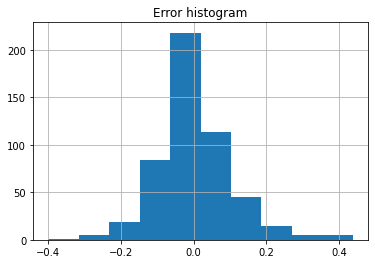

In [ ]:
#validate assumption 2 - errors are normally distributed with zero mean.
error_df.error.hist()
plt.title('Error histogram')
plt.show()

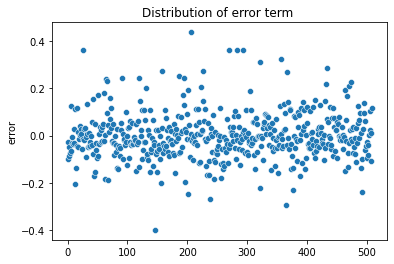

In [ ]:
#validate assumption 3 - errors are independent of each other. No visible pattern in error plotting.
sns.scatterplot(y=error_df.error, x=error_df.index)
plt.title('Distribution of error term ')
plt.show()

In [ ]:
#absolute value of predcition on train set- first 5 records
np.ceil(target_scalar.inverse_transform(y_train))[0:5]

array([[5445.],
       [5478.],
       [4891.],
       [2302.],
       [7572.]])

##### Prediction on Test data set #####

We will perform the same transformation to prepare the data as done on train data. We will use transform method instead of fit_transform.

In [ ]:
#preparing the test data - predictors
X_test = pd.DataFrame(cat_encoder.transform(data_test[cat_cols]), columns=col_names)
scaled_num_data = pd.DataFrame(pred_scalar.transform(data_test[num_cols[0:-1]]), columns=num_cols[0:-1])
X_test= pd.concat([X_test, scaled_num_data], axis=1)

In [ ]:
#preparing the test - target 
y_test = target_scalar.transform(data_test.cnt.values.reshape(-1,1))

In [ ]:
#shape of test_data
print(f'Shape(X_test):{X_test.shape}')
print(f'length(y_test):{len(y_test)}')

Shape(X_test):(219, 36)
length(y_test):219


In [ ]:
#making predicton on X_test
#initialize and train the LR model on choosen columns
# vars = ['temp', 'hum', 'weth_2', 'weth_3','fall', 'summer', 'winter','year_2019', 'windspeed','h_yes']  
X_test_lr = X_test[vars]
y_test_pred = model.predict(X_test_lr)

In [ ]:
# calulating the r2 scrore on test data
r2_score(y_test, y_test_pred)
# We are able to explain the 82.7% of variance in test data.

0.8272837164664857

In [ ]:
rmse_error = sqrt(mean_squared_error(y_test, y_test_pred))
print(f'RMSE(Test Data Set):{rmse_error}')
print(f'RMSE Absolute (Test Data Set): {target_scalar.inverse_transform(np.array(rmse_error).reshape(-1,1))}')

RMSE(Test Data Set):0.0944505681834833
RMSE Absolute (Test Data Set): [[1213.33405626]]


##### Conclusion #####

- Our final model is able to explain ~82% of variance in the data.
- RMSE of model is 0.094(in absolute term 1213 count )
- Features which has major positive impact on prediction are below in descreasing order of sequence.
            1.   temp        :0.492
            2.   year_2019   :0.242
            3.   winter      :0.193
            4.   summer      :0.153
            5.   fall        :0.117
            6.   h_yes       :0.075

- Features which has major negative impact on prediction are below in increasing order of sequence.
            1.   weth_2      :-0.046
            2.   hum         :-0.122
            3.   windspeed   :-0.15
            4.   weth_3      :-0.219


